<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Isolation Forest Anomalies Removal
</p>

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
# Load Data
data = pd.read_csv('aggregated_measurements_data.csv')

In [4]:
# Data Preprocessing/Cleaning

## Parse Dates
data['time'] = pd.to_datetime(data['time'], utc=True)

# Exclude SFxx and SF12 datapoints
data = data[~data['SF'].isin([11, 12])]

## Convert object columns to numeric where possible
numeric_columns = data.select_dtypes(include=['object', 'string']).columns
for col in numeric_columns:
    if col != 'device_id':
        data[col] = pd.to_numeric(data[col], errors='coerce')

## Reset the index to have 'time' as a column again
data.reset_index(inplace=True)


# Total number of rows
total_rows = len(data)

# Identify rows with any NaN or Inf values
rows_with_nan = data.isnull().any(axis=1)
rows_with_inf = data.isin([np.inf, -np.inf]).any(axis=1)
rows_with_issues = rows_with_nan | rows_with_inf

# Count the number of affected rows
affected_rows = rows_with_issues.sum()

# Calculate the percentage of affected rows
affected_percentage = (affected_rows / total_rows) * 100

# Display the results
print(f"Total number of rows: {total_rows}")
print(f"Rows with NaN or Inf: {affected_rows} ({affected_percentage:.2f}%)")

# Drop the affected rows and reset the index
df = data[~rows_with_issues].reset_index(drop=True)

# Final number of rows after cleaning
final_rows = len(df)
final_percentage = (final_rows / total_rows) * 100

print(f"Rows after cleaning: {final_rows} ({final_percentage:.2f}%)")

Total number of rows: 243874
Rows with NaN or Inf: 245 (0.10%)
Rows after cleaning: 243629 (99.90%)


In [5]:
# Anomaly Detection Per Device

# Set desired contamination level
contamination_level = 0.01  # 1% of data points considered anomalies

# Anomaly Detection Function with Selected Features
def detect_anomalies_per_device(device_data, contamination=contamination_level):
    # Sort by 'time' to maintain chronological order
    device_data = device_data.sort_values('time').reset_index(drop=True)
    
    # Feature Selection - Use only the selected sensor data
    features = ['co2', 'humidity', 'pm25', 'pressure', 'temperature', 'rssi', 'snr']
    
    # Ensure all features are numeric
    for col in features:
        device_data[col] = pd.to_numeric(device_data[col], errors='coerce')
    
    # Handle any remaining missing values

    
    # Drop any remaining rows with NaN values in features
    device_data.dropna(subset=features, inplace=True)
    
    # Check if there's enough data to proceed
    if device_data.shape[0] < 1:
        print("Not enough data to process for this device.")
        return pd.DataFrame()
    
    # Feature Scaling
    X = device_data[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize Isolation Forest with custom contamination
    iso_forest = IsolationForest(
        n_estimators=100,
        max_samples='auto',
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the model
    iso_forest.fit(X_scaled)
    
    # Predict anomalies
    device_data['anomaly_score'] = iso_forest.decision_function(X_scaled)
    device_data['anomaly'] = iso_forest.predict(X_scaled)
    device_data['anomaly_label'] = device_data['anomaly'].map({1: 'Normal', -1: 'Anomaly'})
    
    return device_data


# Apply Function to Each Device
device_ids = data['device_id'].unique()
results = []

for device_id in device_ids:
    print(f"Processing data for: {device_id}")
    device_data = data[data['device_id'] == device_id]
    
    # Skip if device_data is empty
    if device_data.empty:
        print(f"No data for device {device_id}. Skipping.")
        continue
    
    device_analyzed = detect_anomalies_per_device(device_data, contamination=contamination_level)
    
    # Only append if the result is not empty
    if not device_analyzed.empty:
        results.append(device_analyzed)
    else:
        print(f"No valid data to process for device {device_id}.")

# Combine Results
if results:
    data_with_anomalies = pd.concat(results, ignore_index=True)
    
    # Separate anomalies and normal data
    anomalies = data_with_anomalies[data_with_anomalies['anomaly'] == -1]
    cleaned_data = data_with_anomalies[data_with_anomalies['anomaly'] == 1]
else:
    print("No valid data was processed for any device.")

Processing data for: ED3
Processing data for: ED0
Processing data for: ED1
Processing data for: ED2
Processing data for: ED4
Processing data for: ED5


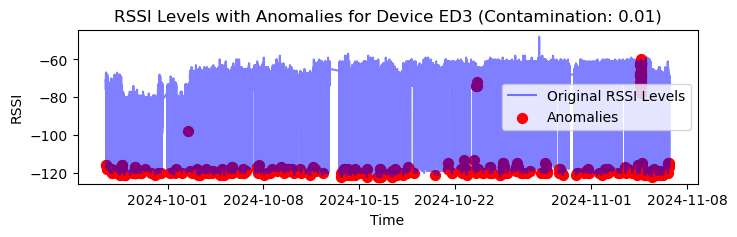

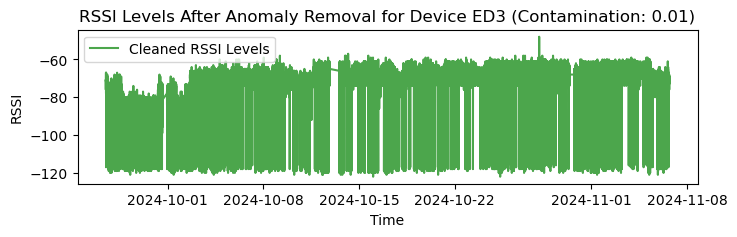

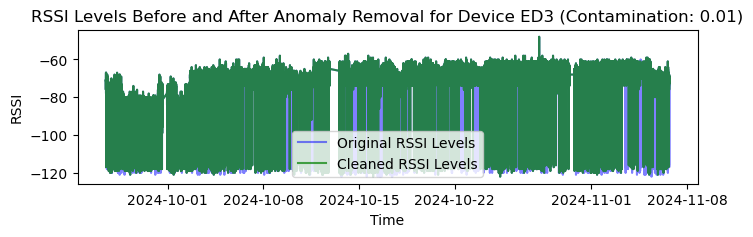

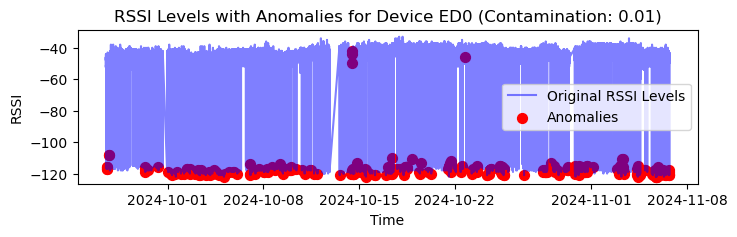

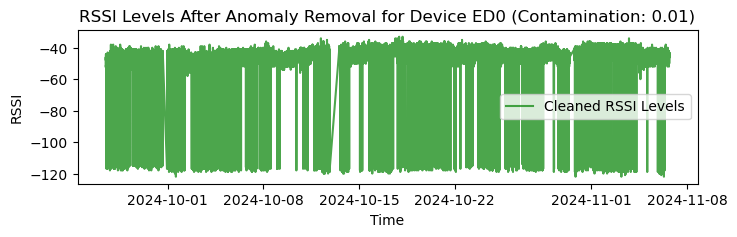

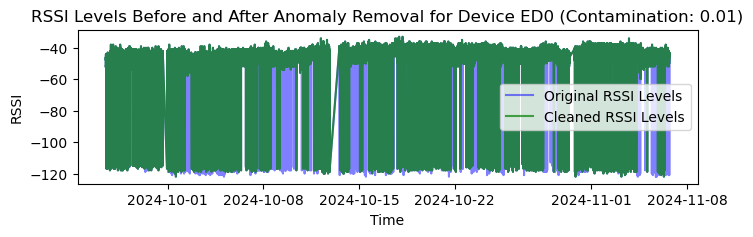

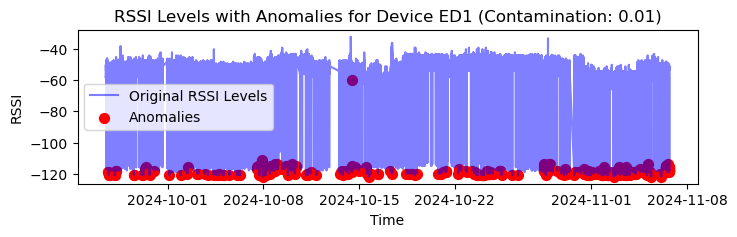

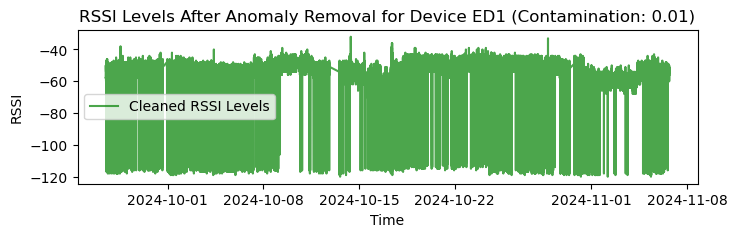

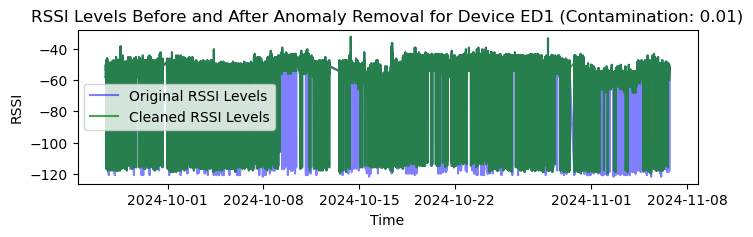

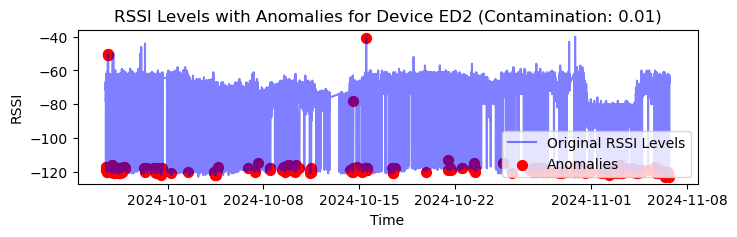

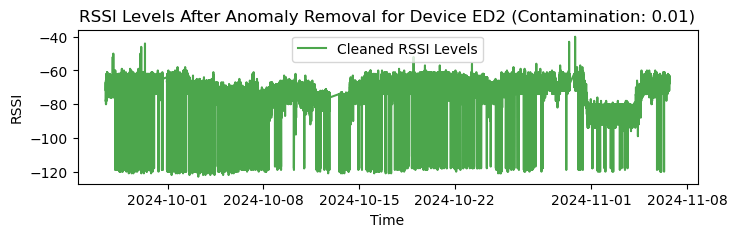

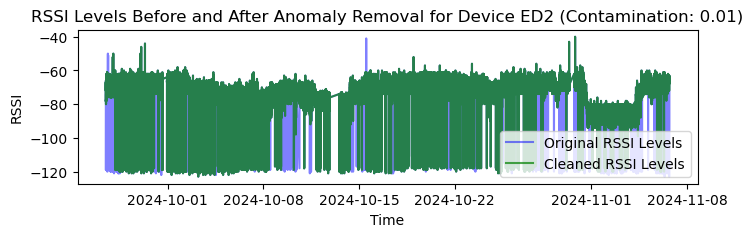

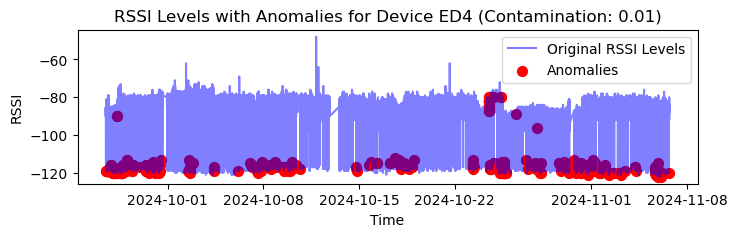

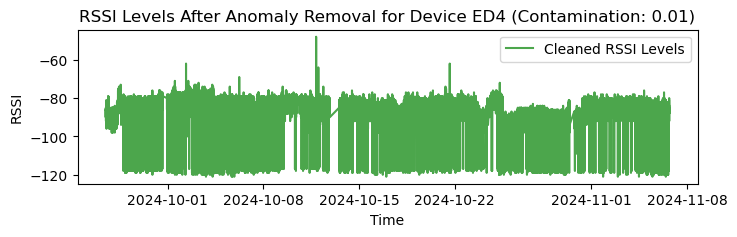

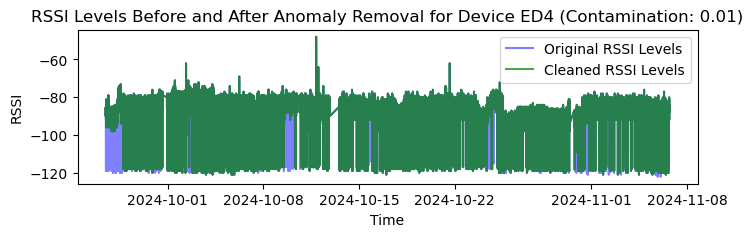

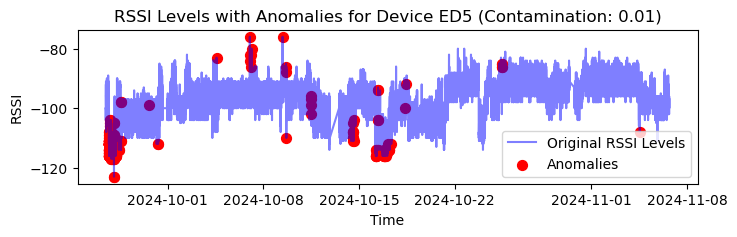

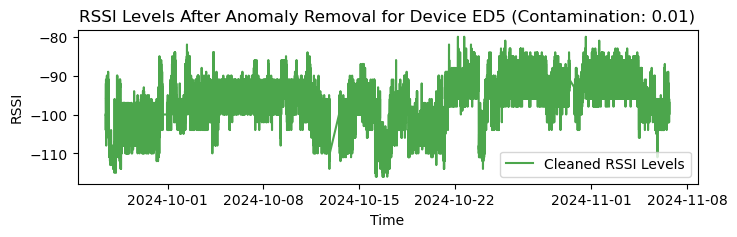

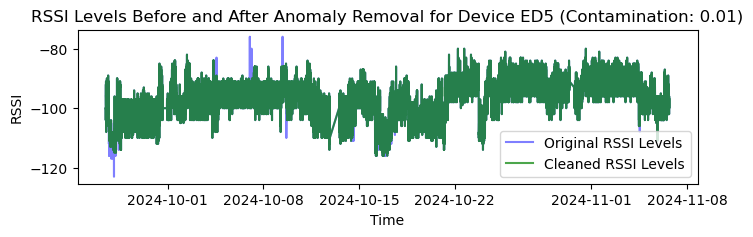

In [6]:
# Data Visualization
# Plot RSSI Levels Before and After Anomaly Removal for Each Device
#CAN BE ANY OTHER VARIABLE

if results:
    for device_id in device_ids:
        device_original = data[data['device_id'] == device_id]
        device_cleaned = cleaned_data[cleaned_data['device_id'] == device_id]
        device_anomalies = anomalies[anomalies['device_id'] == device_id]
        
        if device_original.empty or device_cleaned.empty:
            print(f"Insufficient data to plot for device {device_id}.")
            continue
        
        # Before anomaly removal
        plt.figure(figsize=(8, 2))
        plt.plot(device_original['time'], device_original['rssi'], label='Original RSSI Levels', color='blue', alpha=0.5)
        if not device_anomalies.empty:
            plt.scatter(device_anomalies['time'], device_anomalies['rssi'], color='red', label='Anomalies', s=50)
        plt.xlabel('Time')
        plt.ylabel('RSSI')
        plt.title(f'RSSI Levels with Anomalies for Device {device_id} (Contamination: {contamination_level})')
        plt.legend()
        plt.show()
        
        # After anomaly removal
        plt.figure(figsize=(8, 2))
        plt.plot(device_cleaned['time'], device_cleaned['rssi'], label='Cleaned RSSI Levels', color='green', alpha=0.7)
        plt.xlabel('Time')
        plt.ylabel('RSSI')
        plt.title(f'RSSI Levels After Anomaly Removal for Device {device_id} (Contamination: {contamination_level})')
        plt.legend()
        plt.show()
        
        # Before and after on the same axis
        plt.figure(figsize=(8, 2))
        plt.plot(device_original['time'], device_original['rssi'], label='Original RSSI Levels', color='blue', alpha=0.5)
        plt.plot(device_cleaned['time'], device_cleaned['rssi'], label='Cleaned RSSI Levels', color='green', alpha=0.7)
        plt.xlabel('Time')
        plt.ylabel('RSSI')
        plt.title(f'RSSI Levels Before and After Anomaly Removal for Device {device_id} (Contamination: {contamination_level})')
        plt.legend()
        plt.show()
else:
    print("No data available for plotting.")

In [7]:
# Save Cleaned Data; Anomalies weg :)
if 'cleaned_data' in locals():
    cleaned_data.to_csv('../all_data_files/cleaned_dataset_per_device.csv', index=False)
    print("Cleaned data saved to 'cleaned_dataset_per_device.csv'.")
else:
    print("No cleaned data to save.")

Cleaned data saved to 'cleaned_dataset_per_device.csv'.



=== Table of Parameters to be Compared ===



,Parameter,LDPLM - MW,LDPLM - MW - EP
0,PL(d0) [dB],23.454704,18.276924
1,Path loss exponent (n),4.253935,3.734876
2,Brick Wall Loss (L_c) [dB],8.345156,7.500319
3,Wood Wall Loss (L_w) [dB],2.569075,2.953772
4,CO2 coefficient (a_co2) [dB/unit],-,-0.001759
5,Humidity coefficient (a_hum) [dB/unit],-,-0.141722
6,PM2.5 coefficient (a_pm25) [dB/unit],-,-0.040182
7,Pressure coefficient (a_pres) [dB/unit],-,-0.053076
8,Temperature coefficient (a_temp) [dB/unit],-,-0.166889
9,SNR scaling factor (k_snr),-,1.944184



=== Performance Metrics Comparison ===



,LDPLM - MW,LDPLM - MW - EP
RMSE (Train) [dB],10.530877,8.363322
RMSE (Test) [dB],10.449955,8.282882
R-squared (Train),0.727926,0.828401
R-squared (Test),0.731159,0.831100
Shadowing σ (dB),10.530877,8.363322


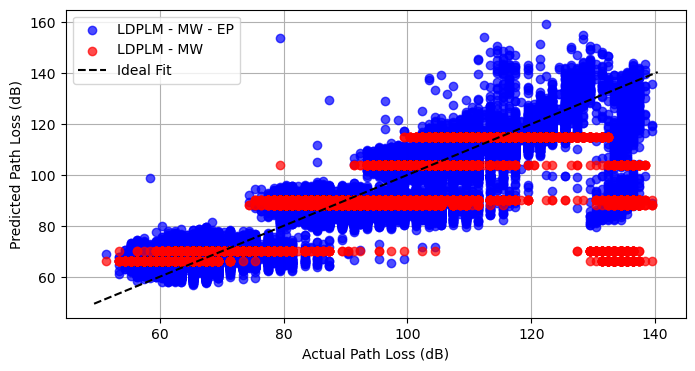

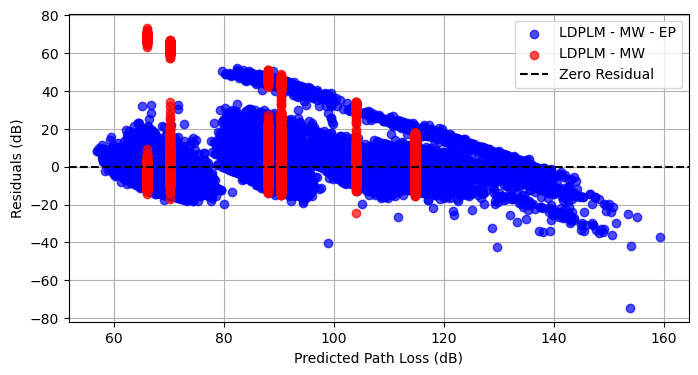

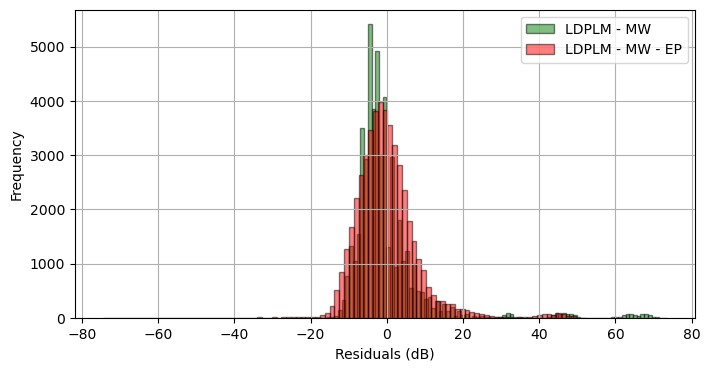


Residual Distribution Values:

LDPLM - MW: Mean:-0.0851 dB, Skewness: 3.9021 dB
LDPLM - MW - EP: Mean:-0.0544 dB, Skewness: 1.849 dB

=== Cross-Validation (5-Fold) ===

Fold 1: 
LDPLM - MW RMSE (Train) = 10.53 dB, R-squared (Train) = 0.7279; 
RMSE (Test) = 10.45 dB, R-squared (Test) = 0.7312

LDPLM - MW - EP RMSE (Train) = 8.36 dB, R-squared (Train) = 0.8284; 
RMSE (Test) = 8.28 dB, R-squared (Test) = 0.8311

Fold 2: 
LDPLM - MW RMSE (Train) = 10.50 dB, R-squared (Train) = 0.7290; 
RMSE (Test) = 10.57 dB, R-squared (Test) = 0.7267

LDPLM - MW - EP RMSE (Train) = 8.33 dB, R-squared (Train) = 0.8294; 
RMSE (Test) = 8.41 dB, R-squared (Test) = 0.8270

Fold 3: 
LDPLM - MW RMSE (Train) = 10.49 dB, R-squared (Train) = 0.7296; 
RMSE (Test) = 10.61 dB, R-squared (Test) = 0.7246

LDPLM - MW - EP RMSE (Train) = 8.33 dB, R-squared (Train) = 0.8295; 
RMSE (Test) = 8.42 dB, R-squared (Test) = 0.8267

Fold 4: 
LDPLM - MW RMSE (Train) = 10.52 dB, R-squared (Train) = 0.7282; 
RMSE (Test) = 10.48 dB, 

In [8]:
#Run the Modelling Notebook and View Results Here
%run "LDPLM - BOTH.ipynb"